In [105]:
import warnings
warnings.filterwarnings('ignore') # disable warnings relateds to versions of tf
import numpy as np
import dianna
import onnx

from metrics import Incremental_deletion

from onnx_tf.backend import prepare
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# # load dataset
data = np.load(Path().absolute().parent / 'data/binary-mnist.npz')
# load testing data and the related labels
X_test = data['X_test'].astype(np.float32).reshape([-1, 28, 28, 1]) / 255

In [3]:
# Load saved onnx model
onnx_model_path = Path('../models', 'mnist_model_tf.onnx')
onnx_model = onnx.load(onnx_model_path)
# get the output node
output_node = prepare(onnx_model, gen_tensor_dict=True).outputs[0]

The predicted class is: digit 0


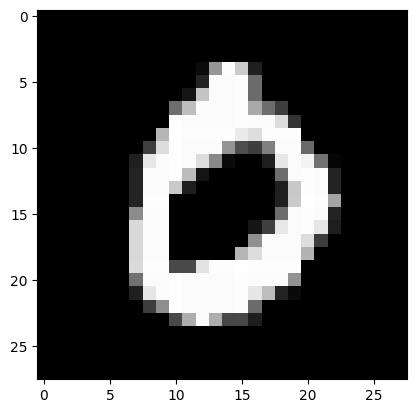

In [4]:
# class name
class_name = ['digit 0', 'digit 1']
# instance index
i_instance = 1
# select instance for testing
test_sample = X_test[i_instance].copy().astype(np.float32)
# model predictions with added batch axis to test sample
predictions = prepare(onnx_model).run(test_sample[None, ...])[f'{output_node}']
pred_class = class_name[np.argmax(predictions)]
print("The predicted class is:", pred_class)
plt.imshow(X_test[i_instance][:,:,0], cmap='gray')  # 0 for channel

In [98]:
# use KernelSHAP to explain the network's predictions
shap_values, segments_slic = dianna.explain_image(onnx_model_path, test_sample, labels=[1],
                                                  method="KernelSHAP", nsamples=1000,
                                                  background=0, n_segments=200, sigma=0,
                                                  axis_labels=('height','width','channels'))

100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


In [97]:
# fill each pixel with SHAP values 
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

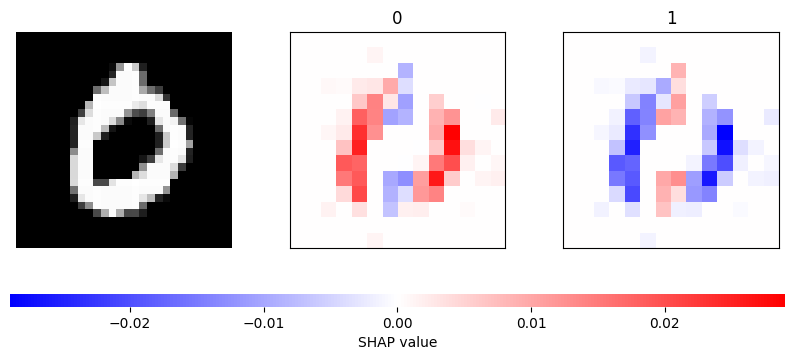

In [7]:
# get the index of predictions
top_preds = np.argsort(-predictions)
inds = top_preds[0]
# Visualize the explanations
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
axes[0].imshow(test_sample, cmap='gray')
axes[0].axis('off')
# get the range for color bar
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
# plot the test image and the attributions on the image for each class
for i in range(2):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].set_title(str(inds[i]))
    axes[i+1].imshow(test_sample, alpha=0.15)
    im = axes[i+1].imshow(m, vmin=-max_val, vmax=max_val, cmap='bwr')
    #axes[i+1].axis('off')
    axes[i+1].set_xticks([])
    axes[i+1].set_yticks([])
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()

In [106]:
import numpy as np

from typing import Callable, Optional, Union
from numpy.typing import NDArray
from dianna import utils
from tqdm import tqdm
from sklearn.metrics import auc
from scipy.stats import mode
from copy import copy
from PIL.Image import Image
from torchtext.vocab import Vectors
from matplotlib.figure import Figure

import seaborn as sns
import matplotlib.pyplot as plt

deleter = Incremental_deletion(model = onnx_model_path, step=1)

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


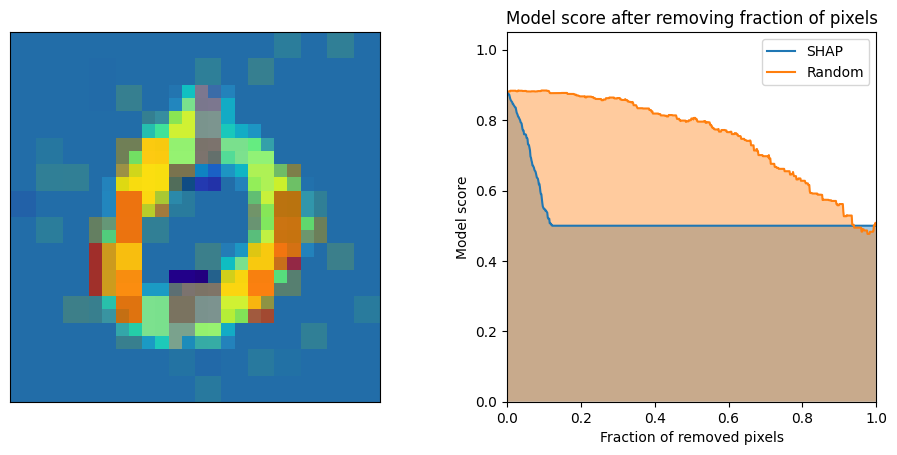

In [109]:

salience_map = fill_segmentation(shap_values[0][0], segments_slic)

results = deleter(test_sample.astype(np.float32), salience_map, batch_size=748, n_samples=1, impute_method='full_mode')

sal = results['salient_scores'] 

sal[sal < 0.5] = 0.5

scores = (results['salient_scores'], results['random_scores'])

_  = deleter.visualize(salience_map, test_sample, scores, ('SHAP', 'Random'))


model = utils.get_function(onnx_model_path)
